libraies

In [1]:
# Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from itertools import product
from tslearn.clustering import TimeSeriesKMeans
from keras.callbacks import EarlyStopping
import json
from tensorflow.keras.models import model_from_json
import pickle
import os

import warnings
warnings.filterwarnings("ignore")

Read the data

In [ ]:
data = pd.read_csv("D_15m_with_time.csv")
# data.describe()
data.head()

,Date,Time,Count
0,2018-03-28,00:00:00,123
1,2018-03-28,00:15:00,105
2,2018-03-28,00:30:00,86
3,2018-03-28,00:45:00,66
4,2018-03-28,01:00:00,54


Make the Date and Time columns in same column (Datetime) and make it as index

In [3]:
# Combine Date and Time columns into a single datetime column and set it as index
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('Datetime', inplace=True)

# Drop Date and Time columns
data.drop(['Date', 'Time'], axis=1, inplace=True)

data.head()

,Count
Datetime,
2018-03-28 00:00:00,123
2018-03-28 00:15:00,105
2018-03-28 00:30:00,86
2018-03-28 00:45:00,66
2018-03-28 01:00:00,54


Normalize the data with minmaxscaler

In [4]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Select the columns we want to normalize
columns_to_normalize = ['Count']

# Normalize the selected columns
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

# Display the scaled data
print("Scaled data :", data)


Scaled data :                         Count
Datetime                     
2018-03-28 00:00:00  0.068128
2018-03-28 00:15:00  0.057464
2018-03-28 00:30:00  0.046209
2018-03-28 00:45:00  0.034360
2018-03-28 01:00:00  0.027251
...                       ...
2019-03-31 22:45:00  0.133886
2019-03-31 23:00:00  0.130332
2019-03-31 23:15:00  0.151066
2019-03-31 23:30:00  0.086493
2019-03-31 23:45:00  0.076422

[35424 rows x 1 columns]


Create time steps (lagged features)

In [5]:
def create_lagged_features(data, num_features):
    
    # Create a copy of the DataFrame to avoid modifying the original
    data_copy = data.copy()

    # Create lagged features for the target variable (1, num_features + 1)
    for i in range(num_features, 0, -1): # shift  from 7 to 1
        data_copy[f'shift{i}'] = data_copy['Count'].shift(i)

    # Replace NaN values with 0
    data_copy.fillna(0, inplace=True)

    return data_copy

In [6]:
sl = 7
data = create_lagged_features(data, sl)
print(data)

                        Count    shift7    shift6    shift5    shift4  \
Datetime                                                                
2018-03-28 00:00:00  0.068128  0.000000  0.000000  0.000000  0.000000   
2018-03-28 00:15:00  0.057464  0.000000  0.000000  0.000000  0.000000   
2018-03-28 00:30:00  0.046209  0.000000  0.000000  0.000000  0.000000   
2018-03-28 00:45:00  0.034360  0.000000  0.000000  0.000000  0.000000   
2018-03-28 01:00:00  0.027251  0.000000  0.000000  0.000000  0.068128   
...                       ...       ...       ...       ...       ...   
2019-03-31 22:45:00  0.133886  0.322867  0.302725  0.271327  0.236967   
2019-03-31 23:00:00  0.130332  0.302725  0.271327  0.236967  0.208531   
2019-03-31 23:15:00  0.151066  0.271327  0.236967  0.208531  0.194905   
2019-03-31 23:30:00  0.086493  0.236967  0.208531  0.194905  0.163507   
2019-03-31 23:45:00  0.076422  0.208531  0.194905  0.163507  0.133886   

                       shift3    shift2    shift1 

# Split the data

In [7]:
def split_data(data, datetime_column, target_column, train_size=0.8, val_size=0.1, test_size=0.1):
    
    # Calculate the split indices
    total_len = len(data) # find total length of data
    train_idx = int(total_len * train_size) 
    val_idx = int(total_len * (train_size + val_size))

    # Split the data (used to select rows and columns by 'integer' location based on their position (pandas))
    train_set = data.iloc[:train_idx]
    val_set = data.iloc[train_idx:val_idx]
    test_set = data.iloc[val_idx:]

    # Split features and target variables
    X_train, y_train = train_set.drop(columns=[target_column]), train_set[target_column] # drop target column from train set and put the new train set to x_train
    X_val, y_val = val_set.drop(columns=[target_column]), val_set[target_column]
    X_test, y_test = test_set.drop(columns=[target_column]), test_set[target_column]

    # Reshape the input data for LSTM 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # add one dimension cause lstm take as input (samples, time_steps, features)
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Reshape the target data for LSTM
    y_train = np.reshape(y_train, (y_train.shape[0], 1)) # add one dimension (samples, features)
    y_val = np.reshape(y_val, (y_val.shape[0], 1))
    y_test = np.reshape(y_test, (y_test.shape[0], 1))

    # dictionary to make key to this 
    split_data = {
        'X_train': X_train, # key holds the training input features wich are used to train the model
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

    # print shapes
    print("Training set shape:", X_train.shape)
    print("Validation set shape:", X_val.shape)
    print("Testing set shape:", X_test.shape)
    # print("y set shape:", y_train.shape)
    # print(y_test)


    return split_data

In [8]:
split_data_dict = split_data(data, 'Datetime', 'Count')
X_train, y_train = split_data_dict['X_train'], split_data_dict['y_train']
X_val, y_val = split_data_dict['X_val'], split_data_dict['y_val']
X_test, y_test = split_data_dict['X_test'], split_data_dict['y_test']

Training set shape: (28339, 7, 1)
Validation set shape: (3542, 7, 1)
Testing set shape: (3543, 7, 1)


# LSTM model

In [9]:
def lstm_individual(X_train, y_train, X_val, y_val, X_test, y_test, individual):
    """
    Evaluate an individual (hyperparameter vector) using the LSTM model and return its mse.
    """

    # Extract hyperparameters from the individual
    HU = int(individual[0])  # Number of LSTM units
    LR = 0.001  # Learning rate
    batch_size = int(individual[1])  # Batch size

    # Select optimizer based on Op parameter
    if int(individual[2]) == 1:
        Op = Adam(learning_rate=LR)
    elif int(individual[2]) == 2:
        Op = SGD(learning_rate=LR)
    elif int(individual[2]) == 3:
        Op = RMSprop(learning_rate=LR)

    # Define Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # to stop training if overfitt , restore optimal weights

    # Define the LSTM model with the extracted hyperparameters
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=HU, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001))) 
    model_lstm.add(Dropout(0.3)) # prop of remove units (neuron)
    model_lstm.add(Dense(units=1)) # add a dense layer with a single output unit (this mean single output not many)
    #  When no activation function is specified, Keras defaults to using the 'tanh' activation function for the LSTM layer.

    # Compile the model with the extracted learning rate
    model_lstm.compile(optimizer=Op, loss='mean_squared_error')

    # Fit the LSTM model with the extracted batch size (verpose = 1 mean Progress bar for each epoch)
    history = model_lstm.fit(X_train, y_train, epochs=150, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

    min_val_loss = min(history.history['val_loss'])  # Minimum validation loss
    # the minimum loss on the validation data is returned

    return {'model': model_lstm, 'min_val_loss': min_val_loss}


# ARDE algorithm

In [13]:
# define function for initialization (that return the vector)
def initialization(D, bL, bU):
    # Initialize parameters within the bounds
    individual = [(bL[i] + random.uniform(0, 1) * (bU[i] - bL[i]))for i in range(D)]
    return individual

In [14]:
def fitness(data, individual):
    # Train LSTM models
    lstm_models = lstm_individual(X_train, y_train, X_val, y_val, X_test, y_test, individual)

    # Calculate sum of min_val_loss for all clusters
    min_val_loss = lstm_models['min_val_loss']

    print("min_val_loss", min_val_loss)

    return min_val_loss


In [15]:
# define function for reinitialization
def reinitialization(z_candidates, P1, fitness_threshold):
    # Reinitialize the population based on fitness threshold
    selected_candidates = [] # list for store the z selected from z_candidates
    for individual in z_candidates:
        if fitness(data, individual) < fitness_threshold:
            selected_candidates.append(individual)
            if len(selected_candidates) >= P1:
               break # Stop once the desired population size is reached
    # If the selected candidates are less than P1, randomly select more candidates from z_candidates
    while len(selected_candidates) < P1:
        random_candidate = random.choice(z_candidates)
        if random_candidate not in selected_candidates:
            selected_candidates.append(random_candidate)
    return selected_candidates

In [16]:
# define function for update FL an FU
def update(G, FL, FU):
    if G > 0:
        FU_new = random.uniform(0, FL) # New random FU
        FL_new = random.uniform(0, FU_new) # New random FL
        FL = FL_new
        FU = FU_new
    else:
        FL = 0.8
        FU = 1
    print(f"G: {G}, FL: {FL}, FU: {FU}")
    return FL, FU  # Return updated values of FL and FU

In [17]:
# define function for mutation
def mutation(z_new_candidates, FL, FU, bL, bU):
    # Apply mutation to each candidate    (enumerate (add index to each element in z_new..., ex: 0: chromosome1))
    mutated_candidates = []
    for index, individual in enumerate(z_new_candidates): 
        # Mutation operation
        FG = random.uniform(FL, FU) # mutation factor
        # Select other indices that are not the same as the current index
        other_indices = [i for i in range(len(z_new_candidates)) if i != index] # see if i!=index add the i in the other_indices
        # Randomly select three other chromosomes for mutation
        selected_indices = random.sample(other_indices, 3)
        z_k, z_l, z_m = [z_new_candidates[i] for i in selected_indices]
        # random.sample() allows you to select a specified number of unique elements from a population without replacement.

        # Perform mutation (this is a vector of the vG)
        vG = [z_k[i] + FG * (z_l[i] - z_m[i]) for i in range(len(individual))] # Starting from index 2

        # Check bounds and adjust if necessary
        for i in range(len(vG)): # if there is values under then the bound make it lower value of bound
            if vG[i] < bL[i]:
                vG[i] = bL[i]
            elif vG[i] > bU[i]: # if there is values upper then the bound make it upper bound value
                vG[i] = bU[i]

        # list of mutation
        mutated_candidates.append(vG)

    return mutated_candidates

In [18]:
# define function for crossover
def crossover(z_mutation, Cr, z_new_candidates):
    # Crossover operation
    crossover_candidates = []
    for individual, vG in zip(z_new_candidates, z_mutation): # this zip put the 2 list in front of each other it mean like z in ... and vG in ...
        uG = np.full(D, -1.0, dtype=float) #as trivial values for initialisation purpose (make vector of -1 values)
        for i in range(len(vG)): # or len(z)
         #here i means j of the article,
         #we compare Ci and Cr to select only one gene from each chromosome
            Ci = random.uniform(0, 1) # random number
            if Ci >= Cr :
                uG[i]= vG[i]
            else :
                uG[i] = individual[i]

        crossover_candidates.append(uG)

    return crossover_candidates

In [19]:
# define function for selection
def selection(z_new_candidates, u_crossover, old_fitness_values=None):
    # Selection operation
    selection_candidates = []
    new_fitness_values = []  # To store the fitness values of the new z_selection
    for individual, uG in zip(z_new_candidates, u_crossover):
        if old_fitness_values is None:
            fitness_individual = fitness(data, individual)  # Calculate fitness if old_fitness_values is not provided
        else:
            fitness_individual = old_fitness_values.pop(0)  # Get the fitness value from the saved list (pop: take the first value and remove it from the list)
        fitness_uG = fitness(data, uG)  # Calculate fitness of uG

        if fitness_uG <= fitness_individual:
            z_next = [uG[i] for i in range(len(uG))]
            new_fitness_values.append(fitness_uG)
        else :
            z_next = [individual[i] for i in range(len(individual))]
            new_fitness_values.append(fitness_individual)

        selection_candidates.append(z_next)

    return selection_candidates, new_fitness_values

In [20]:
# define function for earlystopping
def earlyStopping(best_fitness_history, k):
    """
    Early stopping mechanism to stop optimization if best fitness hasn't improved over k-1 generations.

    Args:
    - best_fitness_history: List containing the best fitness values of previous generations.
    - k: Patience parameter.

    Returns:
    - Boolean: True if early stopping condition is met, False otherwise.
    """
    if len(best_fitness_history) < k:
        return False

    for i in range(1, k):
        if best_fitness_history[-1] != best_fitness_history[-1-i]: # [-1] current
            return False

    return True

In [21]:
def ARDE(P0, P1, FL, FU, Cr, maxG, k):
    best_fitness_history = []  # To store the best fitness values of previous generations
    old_fitness_values = None  # To store the fitness values of the previous z_selection
    for G in range(maxG):
        if G == 0:
            z = [initialization(D, bL, bU) for _ in range(P0)]
            z_new_candidates = reinitialization(z, P1, fitness_threshold)
            FL, FU = update(G, FL, FU) # for update FL and FU
            z_mutation = mutation(z_new_candidates, FL, FU, bL, bU)
            u_crossover = crossover(z_mutation, Cr, z_new_candidates)
            z_selection, fitness_values = selection(z_new_candidates, u_crossover)
            old_fitness_values = fitness_values[:]  # Store the fitness values for future use
        else:
            # z_selection is  the  new generation
            FL, FU = update(G, FL, FU) # for update FL and FU
            z_mutation = mutation(z_selection, FL, FU, bL, bU) # do mutation for the population that commed from the previous selection
            u_crossover = crossover(z_mutation, Cr, z_selection)
            z_selection, fitness_values = selection(z_selection, u_crossover, old_fitness_values)
            old_fitness_values = fitness_values[:]  # Update the old fitness values

            # Store the best fitness value of the current generation
            
            best_fitness = min(fitness_values) # Use the fitness values calculated in the current generation
            best_fitness_history.append(best_fitness)

            # Check for early stopping
            if len(best_fitness_history) >= k and earlyStopping(best_fitness_history, k):
                print("Early stopping triggered at generation", G)
                break

    # Find the best solution among the final population
    best_solution = min(z_selection, key=lambda x: fitness(data, x)) # This finds the minimum element in the iterable z based on the values returned by the function f(x) applied to each element x in z.

    return best_solution

In [22]:
D = 3 # number of hyperparameters
bL = [1 , 32 , 1 ] # Lower bounds
bU = [75 , 500 , 3 ] # Upper bounds // learning rate when he is small the loss small
"""
HU # hidden unit
BS # batch size
Op # optimizer (1-Adam , 2-SGD , 3-RMSPROP)
"""
P0 = 100
fitness_threshold = 0.07 # e
P1 = 10
FL = 0.8 # Mutation lower bounds
FU = 1 # Mutation upper bounds
Cr = 0.7  # Crossover rate
maxG = 10  # Maximum number of generations 100
k = 3  # Early stopping criteria


In [23]:
# Generate some random chromosome candidates
z_candidates = [initialization(D, bL, bU) for i in range(P0)] # got from initialization
for z in z_candidates:
    print([round(x, 2) for x in z])

z_new_candidates = reinitialization(z_candidates, P1, fitness_threshold)
print("/n","the z_new_candidates :")
for z in z_new_candidates:
    print([round(x, 2) for x in z])

z_mutation = mutation(z_new_candidates, FL, FU, bL, bU)
print("/n","the z_mutation :")
for z in z_mutation:
    print([round(x, 2) for x in z])

u_crossover = crossover(z_mutation, Cr, z_new_candidates)
print("/n","the u_crossover :")
for z in u_crossover:
    print([round(x, 2) for x in z])

z_selection, fitness_values = selection(z_new_candidates, u_crossover)
print("/n","the z_selection :")
for z in z_selection:
    print([round(x, 2) for x in z])

# Run the optimization
best_solution = ARDE(P0, P1, FL, FU, Cr, maxG, k)

# Print the optimal solution
print("Optimal solution:", best_solution)

[62.42, 432.76, 1.58]
[71.0, 422.09, 1.53]
[11.89, 293.17, 1.73]
[36.67, 113.29, 1.89]
[26.29, 175.3, 2.17]
[9.16, 435.68, 1.35]
[11.22, 96.39, 2.03]
[2.37, 114.67, 2.55]
[57.95, 348.95, 2.54]
[45.61, 52.45, 2.33]
[2.68, 400.8, 2.85]
[37.82, 90.43, 1.55]
[64.81, 481.22, 1.48]
[30.4, 378.35, 1.66]
[56.18, 182.64, 1.38]
[72.53, 338.55, 1.05]
[34.96, 297.93, 1.27]
[52.82, 192.51, 2.51]
[3.13, 77.74, 2.15]
[62.02, 183.74, 1.98]
[29.65, 197.67, 1.14]
[60.82, 419.71, 2.8]
[1.66, 120.8, 1.25]
[11.05, 304.4, 1.91]
[44.69, 280.86, 1.24]
[73.67, 79.41, 1.89]
[14.88, 403.32, 1.88]
[4.22, 378.17, 1.77]
[42.03, 328.58, 1.09]
[30.96, 321.26, 2.9]
[37.09, 245.62, 1.34]
[69.41, 165.87, 1.26]
[45.61, 194.79, 2.78]
[32.95, 238.81, 2.34]
[12.35, 49.32, 2.88]
[55.58, 160.47, 2.25]
[61.85, 372.37, 1.48]
[74.43, 433.42, 2.2]
[39.86, 481.56, 2.19]
[74.09, 364.31, 1.48]
[6.92, 309.37, 2.22]
[13.82, 290.45, 2.23]
[52.29, 319.73, 2.6]
[45.44, 304.17, 2.52]
[74.57, 273.0, 2.86]
[61.34, 247.03, 2.96]
[5.85, 176.1

train the model to best hyperparamater

In [28]:
def lstm(X_train, y_train, X_val, y_val, X_test, y_test, individual):
    """
    Evaluate an individual (hyperparameter vector) using the LSTM model and return its mse.
    """

    # Extract hyperparameters from the individual
    HU = int(individual[0])  # Number of LSTM units
    LR = 0.001  # Learning rate
    batch_size = int(individual[1])  # Batch size

    # Select optimizer based on Op parameter
    if int(individual[2]) == 1:
        Op = Adam(learning_rate=LR)
    elif int(individual[2]) == 2:
        Op = SGD(learning_rate=LR)
    elif int(individual[2]) == 3:
        Op = RMSprop(learning_rate=LR)

    # Define Early Stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Define the LSTM model with the extracted hyperparameters
    model_lstm = Sequential()
    model_lstm.add(LSTM(units=HU, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.001))) 
    model_lstm.add(Dropout(0.3))
    model_lstm.add(Dense(units=1)) # add a dense layer with a single output unit
    #  When no activation function is specified, Keras defaults to using the 'tanh' activation function for the LSTM layer.

    # Compile the model with the extracted learning rate
    model_lstm.compile(optimizer=Op, loss='mean_squared_error', metrics=['mean_absolute_percentage_error', 'mean_absolute_error', 'root_mean_squared_error'])

    # Fit the LSTM model with the extracted batch size
    history = model_lstm.fit(X_train, y_train, epochs=150, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)

    min_val_loss = min(history.history['val_loss'])  # Minimum validation loss
    min_mape_val_loss = min(history.history['val_mean_absolute_percentage_error']) # Minimum MAPE on validation data
    min_mae_val_loss = min(history.history['val_mean_absolute_error']) # Minimum MAE on validation data
    min_rmse_val_loss = min(history.history['val_root_mean_squared_error'])  # Minimum RMSE on validation data
    # the minimum loss on the validation data is returned

    return {'model': model_lstm, 'min_mse_val_loss': min_val_loss, 'min_mape_val_loss': min_mape_val_loss, 'min_mae_val_loss': min_mae_val_loss, 'min_rmse_val_loss': min_rmse_val_loss}


In [29]:
# Train LSTM models for each cluster using the best hyperparameter vector
lstm_models= lstm(X_train, y_train, X_val, y_val, X_test, y_test, best_solution)

# Calculate sum of min_val_loss for all clusters
min_val_loss = lstm_models['min_mse_val_loss']
min_mape_val_loss = lstm_models['min_mape_val_loss']
min_mae_val_loss = lstm_models['min_mae_val_loss']
min_rmse_val_loss = lstm_models['min_rmse_val_loss']

print("min_mse_val_loss", min_val_loss)
print("min_mape_val_loss", min_mape_val_loss)
print("min_mae_val_loss", min_mae_val_loss)
print("min_rmse_val_loss", min_rmse_val_loss)

Epoch 1/150
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0542 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 264.6125 - root_mean_squared_error: 0.2201 - val_loss: 0.0084 - val_mean_absolute_error: 0.0649 - val_mean_absolute_percentage_error: 44.0463 - val_root_mean_squared_error: 0.0914
Epoch 2/150
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0079 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 3025.6157 - root_mean_squared_error: 0.0889 - val_loss: 0.0047 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 23.9283 - val_root_mean_squared_error: 0.0688
Epoch 3/150
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0054 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 567.5143 - root_mean_squared_error: 0.0734 - val_loss: 0.0031 - val_mean_absolute_error: 0.0390 - val_mean_absolute_percentage_error: 23.5536 - val_root_mean_squared_error: 0.0556
Epoch 4/150
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

save model

In [45]:
# Define the path where you want to save the files
save_path = "base_15min_model"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the model architecture as JSON
architecture_path = os.path.join(save_path, "lstm_model_architecture.json")
with open(architecture_path, "w") as json_file:
    json_file.write(lstm_models['model'].to_json())

# Save the model weights
weights_path = os.path.join(save_path, "lstm_model_weights.weights.h5")
lstm_models['model'].save_weights(weights_path)


make predictions for test set

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


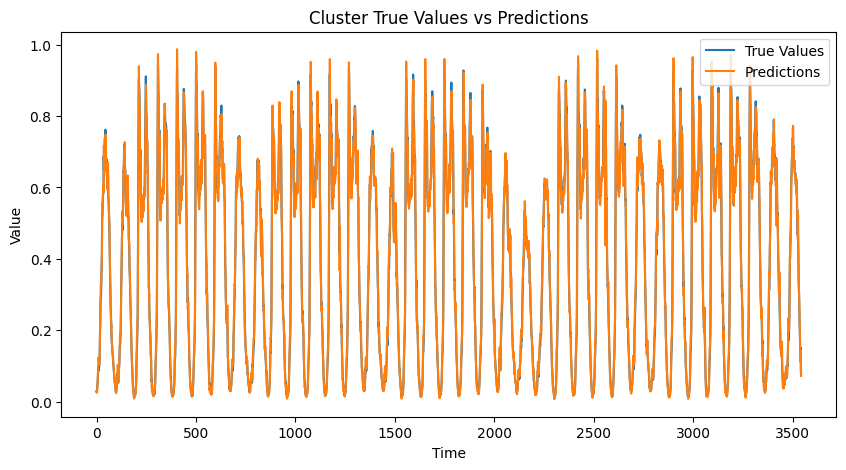

[[0.02937564]
 [0.0249047 ]
 [0.0272015 ]
 ...
 [0.11214307]
 [0.14247712]
 [0.07201979]]


In [39]:
def make_predictions(lstm_models, X_test, y_test):

    model_lstm = lstm_models['model']

    # Make predictions using the LSTM model
    predictions = model_lstm.predict(X_test) # .flatten()

    # Plot true values and predictions for the current cluster
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.title(f'Cluster True Values vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # print(predictions)

    return predictions

# Make predictions on the test set for each cluster using the trained LSTM models
test_predictions = make_predictions(lstm_models, X_test, y_test)
print(test_predictions)

make predition for specefic days

111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


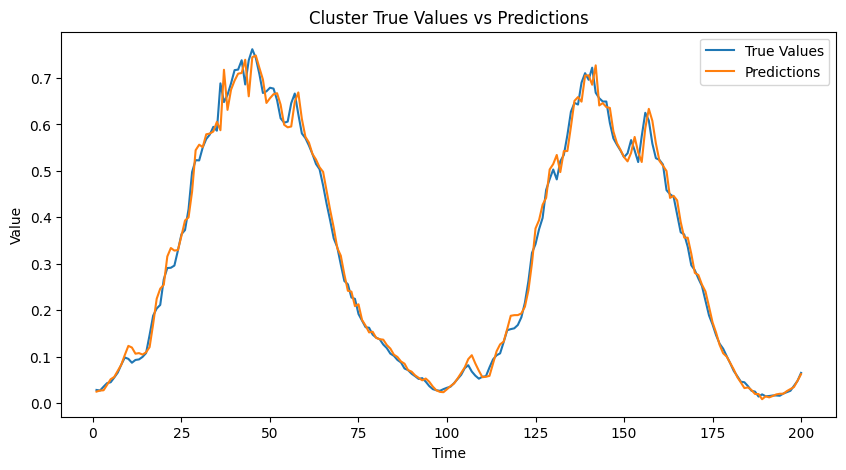

In [31]:
def make_predictions(lstm_models, X_test, y_test, start_day=0, days_to_plot=15):
    """
    Make predictions using the provided LSTM model and plot the true values and predictions.

    Parameters:
    lstm_models (dict): Dictionary containing the trained LSTM model.
    X_test (numpy array): Test data features.
    y_test (numpy array): True values for the test data.
    start_day (int): The starting day for plotting the predictions.
    days_to_plot (int): The number of days to plot.

    Returns:
    numpy array: The predictions made by the LSTM model.
    """

    model_lstm = lstm_models['model']

    # Make predictions using the LSTM model
    predictions = model_lstm.predict(X_test)

    # Determine the range to plot
    end_day = start_day + days_to_plot

    # Ensure the range does not exceed the length of the data
    if end_day > len(y_test):
        end_day = len(y_test)

    # Plot true values and predictions for the specified range
    plt.figure(figsize=(10, 5))
    plt.plot(range(start_day, end_day), y_test[start_day:end_day], label='True Values')
    plt.plot(range(start_day, end_day), predictions[start_day:end_day], label='Predictions')
    plt.title('Cluster True Values vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    return predictions

# Assuming lstm_models, X_test, and y_test are already defined and contain the appropriate data
predictions = make_predictions(lstm_models, X_test, y_test, start_day=1, days_to_plot=200)


convert predictions from scaled to real values

In [32]:
# Inverse transform the scaled predictions to get the original values
# Assuming 'scaler' is the MinMaxScaler object 
original_predictions = scaler.inverse_transform(test_predictions) 

print(original_predictions)

[[ 57.586086]
 [ 50.03913 ]
 [ 53.916138]
 ...
 [197.2975  ]
 [248.50137 ]
 [129.5694  ]]


In [33]:
y_test_true = scaler.inverse_transform(y_test)
print(y_test_true)

[[ 55.]
 [ 56.]
 [ 54.]
 ...
 [263.]
 [154.]
 [137.]]


# true values

In [35]:
def calculate_mse_true(original_predictions, y_test_true):
    mse_true = np.mean(np.square(original_predictions - y_test_true))
    return mse_true

mse_true = calculate_mse_true(original_predictions, y_test_true)

# Print MSE
print("MSE_true :" , mse_true)

MSE_true : 2216.9731724738785


In [36]:
def calculate_mape_true(original_predictions, y_test_true):
    # Ensure non-zero division
    epsilon = 1e-10
    
    # Calculate absolute percentage errors
    # ape = np.abs((y_test - test_predictions) / np.maximum(np.abs(y_test), epsilon))
    ape = np.abs((y_test_true - original_predictions) / np.maximum(y_test_true, epsilon))
    
    # Calculate mean of absolute percentage errors
    mape_true = np.mean(ape) * 100
    return mape_true

mape_true = calculate_mape_true(original_predictions, y_test_true)
# Print MSE
print("MAPE_true :" , mape_true)

MAPE_true : 7.073243089047418


In [37]:
def calculate_mae_true(original_predictions, y_test_true):
    # Calculate absolute differences
    absolute_diff = np.abs(y_test_true - original_predictions)
    
    # Calculate mean of absolute differences
    mae_true = np.mean(absolute_diff)
    return mae_true

mae_true = calculate_mae_true(original_predictions, y_test_true)
# Print MAE
print("MAE_true :" , mae_true)

MAE_true : 32.509915695061224


In [38]:
def calculate_rmse_true(original_predictions, y_test_true):
    # Calculate squared differences
    squared_diff = np.square(y_test_true - original_predictions)
    
    # Calculate mean of squared differences
    mse_true = np.mean(squared_diff)
    
    # Calculate square root of the mean squared differences
    rmse_true = np.sqrt(mse_true)
    
    return rmse_true

rmse_true = calculate_rmse_true(original_predictions, y_test_true)
# Print RMSE
print("RMSE_true :" , rmse_true)

RMSE_true : 47.084744583292355


save results into file

In [44]:
# The content to be written to the file
content = f"""The result of applying LSTM model to all data (15 min): 
- MSE : {mse_true}
- MAPE : {mape_true}
- MAE : {mae_true}
- RMSE : {rmse_true}
"""

# Append the content to a file
with open('results.txt', 'a') as file:
    file.write(content)

print("Results have been saved to 'results.txt'")

Results have been saved to 'results.txt'
